# How should we normalize line drawings?

Typically we normalize images using the imagenet mean ([0.485, 0.456, 0.406]) and std [0.229, 0.224, 0.225]. Where do these numbers come from, and are they appropriate for the line drawings?

These numbers come from loading each imagenet training image (1281167 images) and computing the mean red, green, blue for each image. That gives you 1281167 RED values, which average 0.485, and have a standard deviatio of 0.229, and so on for GREEN, and BLUE.

Then during training, we z-score each channel of each image, so that the RGB values range between -2.5 and 2.5 (or so), where "zero" means the amount of R,G,B matches the mean amount of R,G,B in any training image.

There's a couple of weirnesses about this. First, it does muck with the normal color balance, so if something was yellow (say a perfect balance of red and green), it might be more greenish-yellow after the z-score (because given the color balance the z-scores would have a different red/green ratio). Maybe this doesn't matter because deepnets can just learn whatever these numbers mean "to them" so it doesn't matter what it means "to us".

We could "fix" this issue, however, by just using the average "mean" and average "std" across channels for each channel. i.e., set our normalization stats to mean=[0.449,0.449,0.449] and std =[0.226, 0.226, 0.226]). That would keep the balance between channels.


In [1]:
import torch
import numpy as np

red = .8
green = .8
print(f"standard rgb values: ratio red/green {red:3.3f}/{green:3.3f} = {red/green:3.3f}") 

z_red = (.8 - 0.485)/ 0.229
z_green = (.8 - 0.456) / 0.224
print(f"z-scored imagenet stats: ratio red/green {z_red:3.3f}/{z_green:3.3f} = {z_red/z_green:3.3f}")

z_red = (.8 - 0.449)/ 0.226
z_green = (.8 - 0.449) / 0.226
print(f"z-scored mean imagenet stats: ratio red/green {z_red:3.3f}/{z_green:3.3f} = {z_red/z_green:3.3f}")


standard rgb values: ratio red/green 0.800/0.800 = 1.000
z-scored imagenet stats: ratio red/green 1.376/1.536 = 0.896
z-scored mean imagenet stats: ratio red/green 1.553/1.553 = 1.000


One other thing to keep in mind, however, is that the "stats" for line-drawings are very different than for RGB images. I'm going to recommend that we "flip" our line drawings (1-RGB values) so that the lines are "white" against a black background, and we can kind of think of the resulting image as an "activation map" where higher values correspond to "where the edges/lines appear".


In [2]:
import os
import torch.nn as nn
from torchvision.datasets import ImageNet
from torchvision import transforms

class InvertTensorImageColors(nn.Module):
    def __init__(self):
        super(InvertTensorImageColors, self).__init__()

    def __call__(self, img):
        # Check if the image is in uint8 format
        if img.dtype == torch.uint8:
            return 255 - img
        # assume the image is in float format
        else:
            return 1 - img

In [ ]:
style_name = "anime_style"
split = "train"
root_directory = os.path.join(os.environ['SHARED_DATA_DIR'], 'imagenet1k-line', f"imagenet1k-{style_name}")
transform = transforms.Compose([
    transforms.Resize(256),
    transforms.ToTensor(),
    InvertTensorImageColors(),
])
dataset = ImageNet(root_directory, split=split, transform=transform)
assert len(dataset)==1281167, f"Expected 1281167 val images, got {len(dataset)}"

dataset

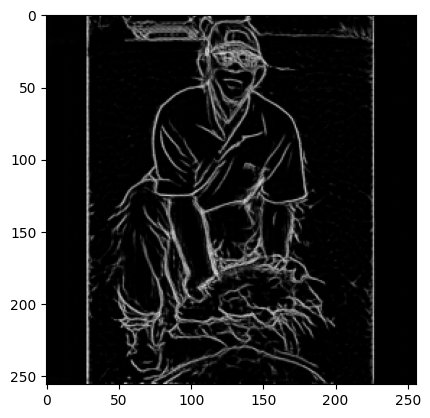

In [3]:
import matplotlib.pyplot as plt

img,label = dataset[0]
plt.imshow(img.moveaxis(0,2), vmin=0, vmax=1);

When you look at the histogram of pixel values, you'll find that it is highly "non-normal", because most of the pixels are black. We really shouldn't characterize non-normal distributions with "means" and "stds". However, if we look at the non-zero values, the distribution is fairly normal. So I think what we want to do is determine the mean and std of the non-zero pixel values for the line drawings.


<Axes: ylabel='Count'>

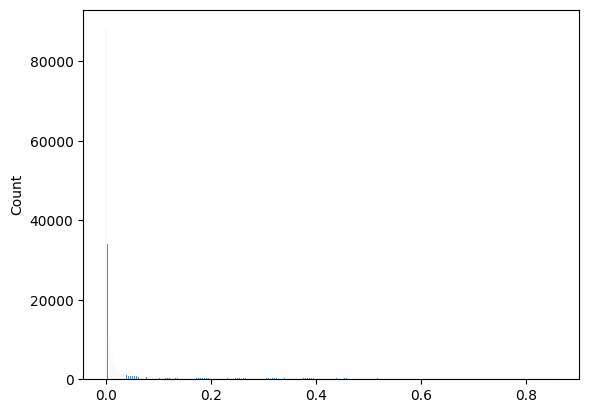

In [4]:
import seaborn as sns

sns.histplot(img.flatten())

avg_non_zero_value: 0.120
avg_non_zero_value/0.226 : 0.532


<Axes: ylabel='Count'>

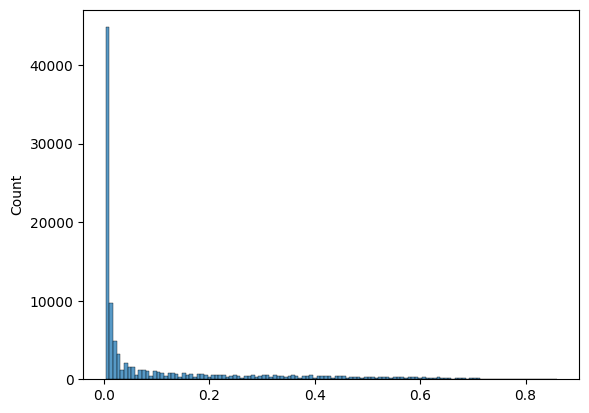

In [5]:
avg_non_zero_value = img[img > 0].mean()
print(f"avg_non_zero_value: {avg_non_zero_value:3.3f}")
print(f"avg_non_zero_value/0.226 : {avg_non_zero_value/0.226:3.3f}")
sns.histplot(img[img > 0].flatten())

How does this compare to the average non-zero value of the original RGB images after the mean is sutracted? Let's do a quick comparison.

In [57]:
root_directory = os.path.join(os.environ['SHARED_DATA_DIR'], 'imagenet1k-256')
transform = transforms.Compose([
    transforms.Resize(256),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.449, 0.449, 0.449], std=[1.0,1.0,1.0]), # only mean adjusting
])
dataset_rgb = ImageNet(root_directory, "train", transform=transform)
dataset_rgb

Dataset ImageNet
    Number of datapoints: 1281167
    Root location: /n/alvarez_lab_tier1/Users/alvarez/datasets/imagenet1k-256
    Split: train
    StandardTransform
Transform: Compose(
               Resize(size=256, interpolation=bilinear, max_size=None, antialias=None)
               ToTensor()
               Normalize(mean=[0.449, 0.449, 0.449], std=[1.0, 1.0, 1.0])
           )

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


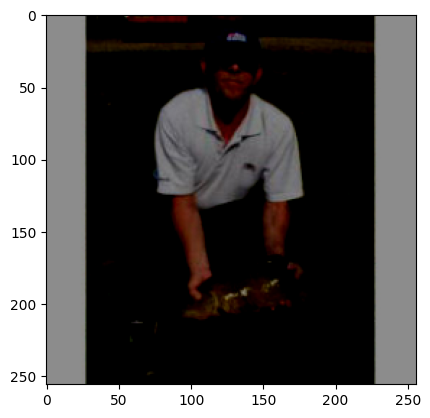

In [48]:
img,label = dataset_rgb[0]
plt.imshow(img.moveaxis(0,2));

<Axes: ylabel='Count'>

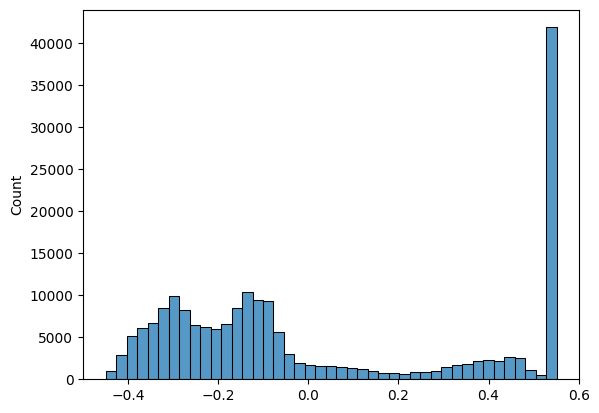

In [49]:
sns.histplot(img.flatten())

avg_non_zero_value: 0.435
avg_non_zero_value/0.226 : 1.925


<Axes: ylabel='Count'>

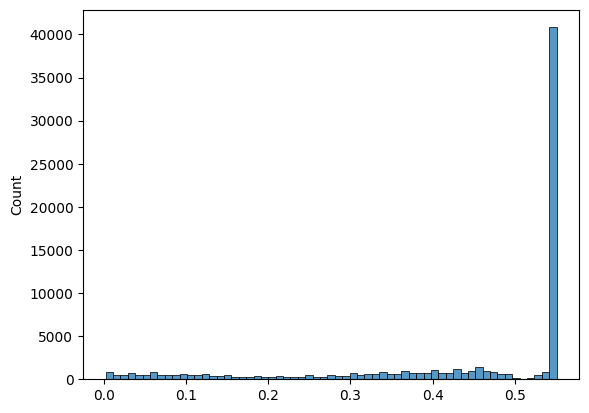

In [53]:
avg_non_zero_value = img[img > 0].mean()
print(f"avg_non_zero_value: {avg_non_zero_value:3.3f}")
print(f"avg_non_zero_value/0.226 : {avg_non_zero_value/0.226:3.3f}")
sns.histplot(img[img > 0].flatten())

So for this particular image, z-scoring by the imgenet std would lead to initial input activations that were much higher for the RGB model than the line drawing model.

What does this all mean? I think it means we should use dataset-specific stats.

# z-scoring the lines only

OK, last thought is that we should perhaps z-score the lines only, ignoring the background. For that, we need to know the mean and std for line activation values (ignoring the background zeros).


In [14]:
import numpy as np
import torch



tensor([0.0000, 0.0000, 0.8000, 0.8000, 0.8000, 0.0000, 0.0000])

In [16]:
m = .6
std = .2
arr = torch.tensor([0, 0, .3, .4, .6, .7, .8, 0, 0])
z = (arr-m)/std
mask = arr > 0
out = torch.where(mask, z, arr) 
out

tensor([ 0.0000,  0.0000, -1.5000, -1.0000,  0.0000,  0.5000,  1.0000,  0.0000,
         0.0000])

tensor([-2., -2.,  2.,  2.,  2., -2., -2.])

RuntimeError: The size of tensor a (7) must match the size of tensor b (3) at non-singleton dimension 0

# compute RGB stats

Let's make sure our procedure gets something close to the original RGB imagenet stats. I say "something close" because we've resized our images (so the shortest edge is 256 pixels) to improve loading times, so our images are down-sampled copies of the original, which might lead to slight different pixel statistics.

In [3]:
from torch.utils.data import DataLoader
from fastprogress import progress_bar

from PIL import Image
import cv2

def pil_loader(path):
    # open path as file to avoid ResourceWarning (https://github.com/python-pillow/Pillow/issues/835)
    with open(path, 'rb') as f:
        img = Image.open(f)
        return img.convert('RGB')
    
def cv2_loader(path, to_rgb=True):
    img = cv2.imread(path)
    if to_rgb: img = img[:,:,::-1]
    
    return img

def load_image(p, to_rgb=True):
    '''Our default image loader, takes `filename` and returns a PIL Image. 
        Speedwise, turbo_loader > pil_loader > cv2, but cv2 is the most robust, so 
        we try to load jpg images with turbo_loader, fall back to PIL, then cv2.
        
        This fallback behavior is needed, e.g., with ImageNet there are a few images
        that either aren't JPEGs or have issues that turbo_loader crashes on, but cv2 
        doesn't.
    '''
    if p.lower().endswith('.jpg') or p.lower().endswith('.jpeg'): 
        try:
            img = pil_loader(p)
        except:
            img = cv2.imread(p)
            if to_rgb: img = img[:,:,::-1]
    else:
        try:
            img = pil_loader(p)
        except:
            img = cv2.imread(p)
            if to_rgb: img = img[:,:,::-1]
                
    if img is not None and not isinstance(img, Image.Image):
        img = Image.fromarray(img)
        
    return img

# Custom collate function
def custom_collate(batch):
    # Extract images and labels
    images, labels = zip(*batch)
    return images, torch.tensor(labels)

def get_dataloader(dataset, batch_size=256, prefetch_factor=10,
                   num_workers=len(os.sched_getaffinity(0))):
    dataloader = DataLoader(dataset, batch_size=batch_size, num_workers=num_workers, 
                            shuffle=False, pin_memory=True, prefetch_factor=prefetch_factor,
                            collate_fn=custom_collate)
    
    return dataloader

In [4]:
root_directory = os.path.join(os.environ['SHARED_DATA_DIR'], 'imagenet1k-256')
transform = transforms.Compose([
    transforms.Resize(256),
    transforms.ToTensor(),
])
dataset_rgb = ImageNet(root_directory, "train", transform=transform, loader=load_image)

dataloader = get_dataloader(dataset_rgb, batch_size=256, prefetch_factor=2)
dataloader

In [5]:
dataloader.dataset

Dataset ImageNet
    Number of datapoints: 1281167
    Root location: /n/alvarez_lab_tier1/Users/alvarez/datasets/imagenet1k-256
    Split: train
    StandardTransform
Transform: Compose(
               Resize(size=256, interpolation=bilinear, max_size=None, antialias=None)
               ToTensor()
           )

In [10]:
from pdb import set_trace
from collections import defaultdict

stats = defaultdict(list)
for i,(imgs,labels) in enumerate(progress_bar(dataloader)):
    for img in imgs:
        img_flat = img.flatten(start_dim=-2) # flattened over space
        img_mean = img_flat.mean(dim=-1) # averaged over space
        img_std = img_flat.std(dim=-1) # std over space
        stats['mean'].append(img_mean) # store the avg rgb values for this image
        stats['std'].append(img_std) # store the avg rgb values for this image
    # if i==2: break
for k,v in stats.items():
    stats[k] = torch.stack(stats[k])
    print(k, stats[k].shape)

mean torch.Size([1281167, 3])
std torch.Size([1281167, 3])


In [11]:
for k,v in stats.items():
    print(k, stats[k].mean(dim=0))

mean tensor([0.4810, 0.4575, 0.4078])
std tensor([0.2265, 0.2223, 0.2232])


standard imagenet stats:
- mean [0.485, 0.456, 0.406]
- std [0.229, 0.224, 0.225]

our imagenet stats:
- mean [0.4810, 0.4575, 0.4078]
- std [0.2265, 0.2223, 0.2232]

OK, this seems close enough.

# compute line-drawing stats
see dataset_stats_line.ipynb